In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from DLC_for_WBFM.utils.projects.finished_project_data import ProjectData
import napari
import pandas as pd
import numpy as np
from DLC_for_WBFM.utils.feature_detection.class_frame_pair import FramePair



Bad key "text.kerning_factor" on line 4 in
/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
fname = "/scratch/zimmer/Charles/dlc_stacks/worm10-gui_test/project_config.yaml"
project_data = ProjectData.load_final_project_data_from_config(fname, to_load_tracklets=True, to_load_segmentation_metadata=True)

Output files for annotator: /scratch/zimmer/Charles/dlc_stacks/worm10-gui_test/3-tracking/manual_annotation/global2tracklet_manual.pickle, /scratch/zimmer/Charles/dlc_stacks/worm10-gui_test/3-tracking/manual_annotation/manually_split_tracklets.h5, /scratch/zimmer/Charles/dlc_stacks/worm10-gui_test/3-tracking/manual_annotation/split_names.pickle, /scratch/zimmer/Charles/dlc_stacks/worm10-gui_test/3-tracking/manual_annotation/split_times.pickle
Project data for directory:
/scratch/zimmer/Charles/dlc_stacks/worm10-gui_test 
Found the following data files:
============Raw========================
red_data:                 True
green_data:               True
============Annotations================
behavior_annotations:     False
============Training================
df_training_tracklets:    True
============Segmentation===============
raw_segmentation:         True
colored_segmentation:     True
============Traces=====================
red_traces:               True
green_traces:             

In [3]:
# fname = "/home/charles/dlc_stacks/worm3-tracklet_wiggle/project_config.yaml"
# project_data2 = ProjectData.load_final_project_data_from_config(fname, to_load_tracklets=True, to_load_segmentation_metadata=True)

In [4]:
# project_data2.red_traces.head()

# Initialize neurons, order tracklets to get candidates, and add tracklets in a loop

### Initialize

In [3]:
from DLC_for_WBFM.utils.pipeline.tracklet_class import TrackedWorm
from DLC_for_WBFM.utils.training_data.tracklet_to_DLC import translate_training_names_to_raw_names
from tqdm.auto import tqdm

In [4]:
tracklets_and_neurons_class = project_data.tracklets_and_neurons_class
worm_obj = TrackedWorm(detections=tracklets_and_neurons_class, verbose=1)
df_training_data = project_data.df_training_tracklets

In [5]:
worm_obj.initialize_neurons_from_training_data(df_training_data)

In [6]:
worm_obj

Worm with 144 neurons

In [9]:
# worm_obj.global_name_to_neuron

### Order the tracklets and do many-to-one matching

In [141]:
from DLC_for_WBFM.utils.postprocessing.combine_tracklets_and_DLC_tracks import calc_global_track_to_tracklet_distances
from DLC_for_WBFM.utils.external.utils_pandas import dataframe_to_dataframe_zxy_format
from DLC_for_WBFM.utils.external.utils_networkx import dist2conf

In [177]:
del project_data.intermediate_global_tracks

In [178]:
df_global_tracks = project_data.intermediate_global_tracks
# df_global_tracks[('neuron_007', 'z')].replace(0.0, np.nan).plot()

In [126]:

df_tracklets = project_data.df_all_tracklets
# Pre-make coordinates so that the dataframe is not continuously indexed
coords = ['z', 'x', 'y']
all_tracklet_names = list(df_tracklets.columns.levels[0])
list_tracklets_zxy = [df_tracklets[name][coords].to_numpy() for name in tqdm(all_tracklet_names)]

  0%|          | 0/15702 [00:00<?, ?it/s]

In [127]:
min_overlap = 5
d_max = 5
used_names = []

In [128]:
worm_obj.initialize_all_neuron_tracklet_classifiers()

In [142]:
# For each neuron, calculate all tracklet distances (percent inliers)
# If passes threshold 1:
#   Then check z/volume threshold 2:
#     Directly add the tracklets to the neurons within worm_obj
#   Else simply do not add
# Finally, do b_matching

for name, neuron in tqdm(worm_obj.global_name_to_neuron.items()):
    # For now just use the tracklet as defined by the training data
    # this_global_track = worm_obj.get_tracklets_for_neuron(name)[0]
    # this_global_track = this_global_track[coords].to_numpy(float)
    
    # New: use the track as produced by the global tracking
    # TODO: confirm that the worm_obj has the same neuron names as leifer
    this_global_track = df_global_tracks[name][coords][:-1].replace(0.0, np.nan).to_numpy(float)
    
    # TODO: calculate distance using percent inliers
    dist = calc_global_track_to_tracklet_distances(this_global_track, list_tracklets_zxy, all_tracklet_names, used_names,
                                                   min_overlap=min_overlap)
    
    # Loop through candidates, and attempt to add
    all_summarized_dist = list(map(lambda x: np.nanquantile(x, 0.1), dist))
    i_sorted_by_median_distance = np.argsort(all_summarized_dist)
    
    for i_tracklet in i_sorted_by_median_distance:
        # Check distance; break because they are sorted by distance
        this_distance = all_summarized_dist[i_tracklet]
        if this_distance > d_max:
            print(f"Breaking at distance: {this_distance}")
            break
        
        candidate_name = all_tracklet_names[i_tracklet]
        candidate_tracklet = df_tracklets[[candidate_name]]
        conf = dist2conf(this_distance)
        is_match_added = neuron.add_tracklet(i_tracklet, conf, candidate_tracklet, metadata=candidate_name,
                                             check_using_classifier=True)
        
        if is_good:
            print(f"Adding tracklet: {candidate_name} with distance {this_distance}")
        else:
            print(f"Not adding {candidate_name}")
        
    break

  0%|          | 0/144 [00:00<?, ?it/s]

Adding tracklet: tracklet_0002118
0.0
Adding tracklet: tracklet_0008759
0.0
Adding tracklet: tracklet_0010753
0.0
Adding tracklet: tracklet_0008866
0.0
Adding tracklet: tracklet_0008891
0.0
Adding tracklet: tracklet_0003913
0.0
Adding tracklet: tracklet_0018447
0.0
Adding tracklet: tracklet_0003830
0.0
Adding tracklet: tracklet_0003826
0.0
Adding tracklet: tracklet_0003715
0.0
Adding tracklet: tracklet_0001377
0.0
Adding tracklet: tracklet_0018384
0.0
Adding tracklet: tracklet_0003593
0.0
Adding tracklet: tracklet_0013444
0.0
Adding tracklet: tracklet_0018337
0.0
Adding tracklet: tracklet_0003366
0.0
Adding tracklet: tracklet_0003323
0.0
Adding tracklet: tracklet_0009253
0.0
Adding tracklet: tracklet_0013358
0.0
Adding tracklet: tracklet_0007143
0.0
Adding tracklet: tracklet_0001548
0.0
Adding tracklet: tracklet_0007134
0.0
Adding tracklet: tracklet_0015120
0.0
Adding tracklet: tracklet_0001672
0.0
Adding tracklet: tracklet_0011621
0.0
Adding tracklet: tracklet_0011623
0.0
Adding track

In [109]:
from DLC_for_WBFM.utils.pipeline.long_range_matching import b_matching_via_node_copying
from DLC_for_WBFM.utils.pipeline.long_range_matching import combine_tracklets_using_matching

In [ ]:
global_tracklet_neuron_graph = worm_obj.compose_global_neuron_and_tracklet_graph()
final_matching = b_matching_via_node_copying(global_tracklet_neuron_graph)
df_new = combine_tracklets_using_matching(all_tracklet_names, df_tracklets, final_matching)

# Same, using functions

In [7]:
project_path = project_data.project_config.self_path

In [8]:
from DLC_for_WBFM.utils.pipeline.long_range_matching import global_track_matches_from_config
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.debug("test")

DEBUG:root:test


In [ ]:
df_new, final_matching, global_tracklet_neuron_graph, worm_obj = global_track_matches_from_config(project_path, to_save=True, verbose=2, DEBUG=False)

INFO:root:File for mode fdnc exists at precendence: 3/3
INFO:root:Read data from: /scratch/zimmer/Charles/dlc_stacks/worm10-gui_test/3-tracking/postprocessing/leifer_tracks.h5
INFO:root:Using most recently modified file
INFO:root:Starting threads to read data...
INFO:root:First time loading the all tracklets, may take a while...


In [280]:
%debug

> /home/charles/Current_work/repos/dlc_for_wbfm/DLC_for_WBFM/utils/pipeline/long_range_matching.py(308)<setcomp>()
    306             # Add a copy of the node for each edge, which has all the original edges
    307             new_edges = [[new_name, e[1], e[2]] for e in original_edges]
--> 308             global_tracklet_neuron_graph_with_copies.add_edges_from(new_edges)
    309 
    310     # Do normal bipartite matching, such that each tracklet gets a match to some copy of a neuron



ipdb>  q


# Look at performance, and improvement from intermediate global tracks

In [386]:
fname = "/scratch/zimmer/Charles/dlc_stacks/worm10-gui_test/project_config.yaml"
project_data_final = ProjectData.load_final_project_data_from_config(fname, to_load_tracklets=True)

INFO:root:File for mode automatic exists at precendence: 1/3
INFO:root:Read data from: /scratch/zimmer/Charles/dlc_stacks/worm10-gui_test/3-tracking/postprocessing/combined_3d_tracks.h5
INFO:root:Using most recently modified file
INFO:root:Starting threads to read data...
INFO:root:First time loading the all tracklets, may take a while...
INFO:root:File for mode automatic exists at precendence: 3/3
INFO:root:Read data from: /scratch/zimmer/Charles/dlc_stacks/worm10-gui_test/2-training_data/all_tracklets.h5
INFO:root:Using most recently modified file
INFO:root:File for mode automatic exists at precendence: 2/2
INFO:root:Read data from: /scratch/zimmer/Charles/dlc_stacks/worm10-gui_test/3-tracking/global2tracklet.pickle
INFO:root:Using most recently modified file
INFO:root:First time loading the raw cluster dataframe, may take a while...


Output files for annotator: /scratch/zimmer/Charles/dlc_stacks/worm10-gui_test/3-tracking/manual_annotation/global2tracklet_manual.pickle, /scratch/zimmer/Charles/dlc_stacks/worm10-gui_test/3-tracking/manual_annotation/manually_split_tracklets.h5, /scratch/zimmer/Charles/dlc_stacks/worm10-gui_test/3-tracking/manual_annotation/split_names.pickle, /scratch/zimmer/Charles/dlc_stacks/worm10-gui_test/3-tracking/manual_annotation/split_times.pickle


INFO:root:Read all data


Project data for directory:
/scratch/zimmer/Charles/dlc_stacks/worm10-gui_test 
Found the following data files:
============Raw========================
red_data:                 True
green_data:               True
============Annotations================
behavior_annotations:     False
============Training================
df_training_tracklets:    True
============Segmentation===============
raw_segmentation:         True
colored_segmentation:     True
============Traces=====================
red_traces:               True
green_traces:             True



In [387]:
df_global_tracks = project_data_final.intermediate_global_tracks
df_final = project_data_final.final_tracks
np.unique(df_final['neuron_001']['raw_tracklet_id'].dropna())

array([  801.,  2192.,  2840.,  3830.,  7134.,  7143.,  7601.,  8658.,
        9904., 10060., 10676., 10748., 12358., 13444., 15347., 16410.,
       17450., 18337.])

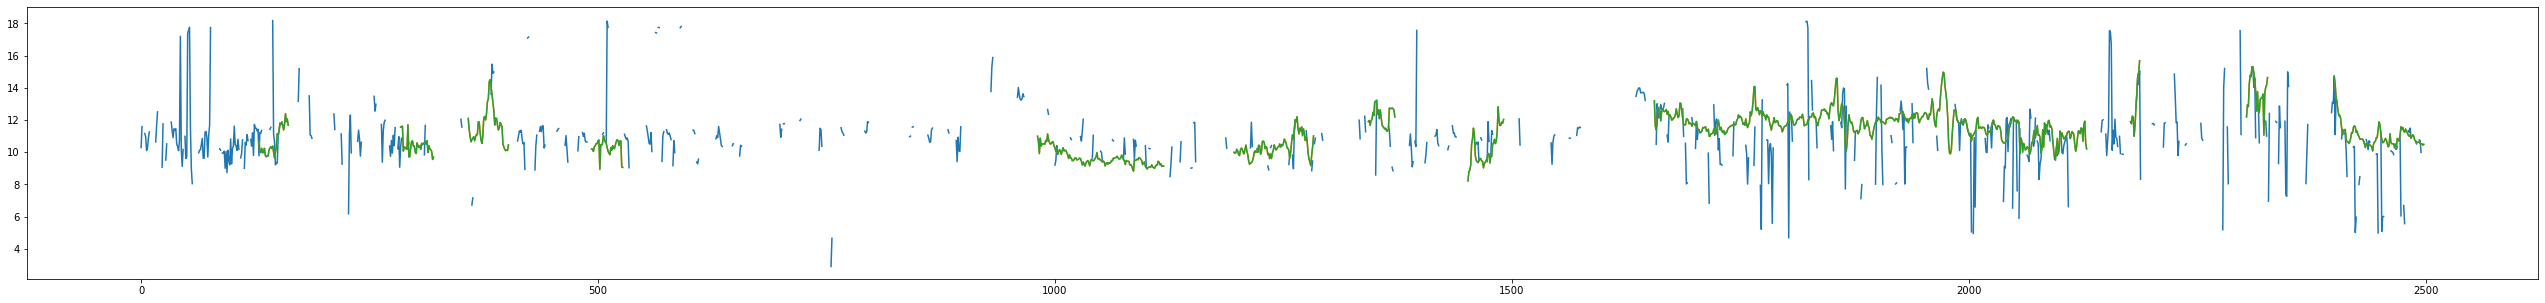

In [388]:
n = 'neuron_001'

plt.figure(figsize=(45,5))
df_global_tracks[n]['z'].replace(0, np.nan).plot()
df_new[n]['z'].plot()
df_final[n]['z'].plot()

In [389]:
project_data.which_training_frames

[1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001]

In [391]:
df_training_data

bodyparts tracklet_0012358                                                   \
coords                   z           x           y likelihood raw_neuron_id   
0                11.938685  460.630640  579.105540   0.509339         106.0   
1                11.768766  459.930506  587.662247   0.603110          98.0   
2                11.694199  462.653889  592.806141   0.608984          99.0   
3                12.027528  464.391869  594.488130   0.497688          94.0   
4                12.081451  464.859793  591.918236   0.439350          98.0   
5                11.942532  471.557482  591.241745   0.520358          99.0   
6                11.679048  481.950944  582.005162   0.464217         101.0   
7                11.342823  493.994361  570.197761   0.469542         104.0   
8                11.205919  507.679739  555.131667   0.525858          95.0   
9                11.016922  512.228516  540.371411   0.529176          89.0   

bodyparts                        tracklet_0012405                          \
coords    brightness_red  volume                z           x           y   
0                34641.0  1071.0         6.855850  260.534651  501.272936   
1                31600.0   895.0         6.922629  260.707140  495.506856   
2                32374.0   886.0         6.994180  263.516688  497.972374   
3                34583.0   995.0         6.931070  264.849939  495.464213   
4                35248.0  1049.0         6.694420  266.822970  493.609533   
5                35707.0  1072.0         6.718500  267.497862  494.006632   
6                34675.0   988.0         6.968202  272.133324  493.108126   
7                36357.0  1062.0         7.134259  279.720656  490.931917   
8                38962.0  1138.0         7.041103  283.153602  490.867370   
9                41485.0  1224.0         7.055998  283.458284  490.199415   

bodyparts  ... tracklet_0014958                       tracklet_0014959  \
coords     ...    raw_neuron_id brightness_red volume                z   
0          ...            171.0         5621.0  317.0        17.994650   
1          ...            158.0         6062.0  331.0        17.015607   
2          ...            164.0         5919.0  325.0        17.496892   
3          ...            159.0         6152.0  334.0        16.455936   
4          ...            165.0         5952.0  325.0        16.916552   
5          ...            165.0         5913.0  325.0        16.925693   
6          ...            164.0         5813.0  320.0        16.879814   
7          ...            167.0         5827.0  320.0        16.968157   
8          ...            164.0         5850.0  321.0        16.919271   
9          ...            162.0         6047.0  337.0        16.476753   

bodyparts                                                                  \
coords              x           y likelihood raw_neuron_id brightness_red   
0          611.562193  671.065091   0.298282         174.0         2243.0   
1          598.999527  698.670135   0.302837         154.0         4229.0   
2          588.274517  720.192680   0.313620         167.0         2896.0   
3          575.992772  738.764804   0.288731         156.0         3597.0   
4          558.859280  752.152135   0.256201         158.0         5081.0   
5          546.105956  763.153529   0.314893         161.0         5087.0   
6          542.347056  762.114653   0.319148         160.0         4518.0   
7          541.767912  755.554603   0.311812         164.0         4899.0   
8          546.948627  743.938684   0.323226         162.0         4224.0   
9          551.044568  731.801494   0.293327         161.0         4151.0   

bodyparts         
coords    volume  
0          110.0  
1          220.0  
2          146.0  
3          180.0  
4          265.0  
5          268.0  
6          240.0  
7          264.0  
8          236.0  
9          222.0  

[10 rows x 1008 columns]

In [359]:
from DLC_for_WBFM.utils.projects.utils_filenames import pickle_load_binary
fname = "/scratch/zimmer/Charles/dlc_stacks/worm10-gui_test/3-tracking/global2tracklet.pickle"
g2t = pickle_load_binary(fname)

In [360]:
'tracklet_0012358' in g2t['neuron_001']

False

In [361]:
for i, (name, neuron) in enumerate(tqdm(worm_obj.global_name_to_neuron.items())):
    print(name)
    print('tracklet_0012358' in neuron.get_raw_tracklet_names())
    
    n = neuron.name_in_graph
    print(n)
    neighbors = neuron.neuron2tracklets.get_all_matches(name=n)
    # print(neighbors)
    print('tracklet_0012358' in [neuron.neuron2tracklets.nodes(data=True)[n]['metadata'] for n in neighbors])
    break

  0%|          | 0/144 [00:00<?, ?it/s]

neuron_001
True
bipartite_0_frame_0_neuron_001
True


In [362]:
neuron.neuron2tracklets

MatchesAsGraph object with 1 class A nodes and 19 class B nodes, with 19 edges

In [365]:
n = global_tracklet_neuron_graph.raw_name_to_network_name('neuron_001')
print(n)
'tracklet_0012358' in [global_tracklet_neuron_graph.nodes(data=True)[n]['metadata'] for n in neighbors]

bipartite_0_frame_0_neuron_001


True

In [366]:
for n in worm_obj.global_name_to_neuron.values():
    try:
        print(n.neuron2tracklets.nodes(data=True)['bipartite_1_trackletGroup_1_tracklet_0000000'])
    except KeyError:
        pass

{'bipartite': 1, 'group_ind': 0, 'local_ind': 2, 'metadata': 'tracklet_0000000'}


Neuron neuron_001 (index=0) with 19 tracklets from time 1656 to 1479

# Debug getting tracklets using project data

In [383]:

n = 'neuron_002'
project_data.tracklet_annotator.calculate_tracklets_for_neuron(n)

TypeError: 'NoneType' object is not subscriptable

In [380]:
final_matching = b_matching_via_node_copying(global_tracklet_neuron_graph)

INFO:root:Matching using b_matching_via_node_copying


In [382]:
final_matching.get_mapping_0_to_1(unique=False)['neuron_092']
# final_matching.get_mapping_pair_to_conf()

['tracklet_0014849']

In [372]:
n = worm_obj.global_name_to_neuron['neuron_092']
print(n)
'tracklet_0012358' in [global_tracklet_neuron_graph.nodes(data=True)[n]['metadata'] for n in neighbors]

Neuron neuron_092 (index=91) with 1 tracklets from time 1979 to 2094


True

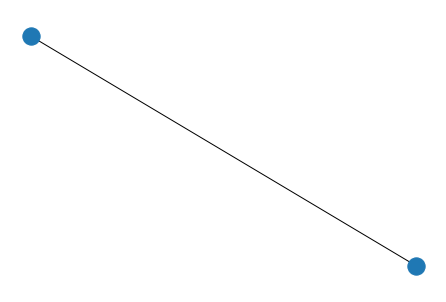

In [379]:
import networkx as nx
nx.draw(n.neuron2tracklets)

# Debug: some neurons are missing, leading to lots of off-by-one errors

In [223]:
worm_obj.global_name_to_neuron['neuron_010']

Neuron neuron_010 (index=9) with 33 tracklets from time 1660 to 1374

In [224]:
worm_obj.global_name_to_neuron['neuron_001']

Neuron neuron_001 (index=0) with 19 tracklets from time 1656 to 1479

In [243]:
# Neuron exists here, but NOT in final_matches...
network_name = global_tracklet_neuron_graph.raw_name_to_network_name('neuron_010')
global_tracklet_neuron_graph.get_all_matches(name=network_name)

['bipartite_1_trackletGroup_1_tracklet_0014400',
 'bipartite_1_trackletGroup_1_tracklet_0000009',
 'bipartite_1_trackletGroup_1_tracklet_0008446',
 'bipartite_1_trackletGroup_1_tracklet_0010119',
 'bipartite_1_trackletGroup_1_tracklet_0005946',
 'bipartite_1_trackletGroup_1_tracklet_0012886',
 'bipartite_1_trackletGroup_1_tracklet_0013143',
 'bipartite_1_trackletGroup_1_tracklet_0004065',
 'bipartite_1_trackletGroup_1_tracklet_0007197',
 'bipartite_1_trackletGroup_1_tracklet_0009142',
 'bipartite_1_trackletGroup_1_tracklet_0007715',
 'bipartite_1_trackletGroup_1_tracklet_0008911',
 'bipartite_1_trackletGroup_1_tracklet_0008307',
 'bipartite_1_trackletGroup_1_tracklet_0006899',
 'bipartite_1_trackletGroup_1_tracklet_0012418',
 'bipartite_1_trackletGroup_1_tracklet_0001340',
 'bipartite_1_trackletGroup_1_tracklet_0012551',
 'bipartite_1_trackletGroup_1_tracklet_0006998',
 'bipartite_1_trackletGroup_1_tracklet_0003527',
 'bipartite_1_trackletGroup_1_tracklet_0005930',
 'bipartite_1_trackl

In [254]:
# This tracklet should only have a single match
# It's training data!
global_tracklet_neuron_graph.get_all_matches(name='bipartite_1_trackletGroup_1_tracklet_0012452')

['bipartite_0_frame_0_neuron_010',
 'bipartite_0_frame_0_neuron_068',
 'bipartite_0_frame_0_neuron_126']

In [249]:
neuron = worm_obj.global_name_to_neuron['neuron_010']
neuron.get_raw_tracklet_names()

['tracklet_0012452',
 'tracklet_0010233',
 'tracklet_0012259',
 'tracklet_0007216',
 'tracklet_0015588',
 'tracklet_0015887',
 'tracklet_0004876',
 'tracklet_0008727',
 'tracklet_0011070',
 'tracklet_0009345',
 'tracklet_0010792',
 'tracklet_0017454',
 'tracklet_0010067',
 'tracklet_0008376',
 'tracklet_0015035',
 'tracklet_0001597',
 'tracklet_0015193',
 'tracklet_0008490',
 'tracklet_0004229',
 'tracklet_0007199',
 'tracklet_0015074',
 'tracklet_0014182',
 'tracklet_0016288',
 'tracklet_0012470',
 'tracklet_0007057',
 'tracklet_0017620',
 'tracklet_0006034',
 'tracklet_0015637',
 'tracklet_0011491',
 'tracklet_0017572',
 'tracklet_0004602',
 'tracklet_0015710',
 'tracklet_0009980']

In [256]:
# neuron.neuron2tracklets.get_nodes_of_class(1)

In [258]:
# df_training_data.loc(axis=1)[:, 'z']

In [259]:
# This should not be an error
final_matching.get_mapping_0_to_1()['neuron_010']

KeyError: 'neuron_010'

In [271]:
project_data.which_training_frames

[1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001]

In [260]:
tracklets_and_neurons_class = project_data.tracklets_and_neurons_class
worm_obj_raw = TrackedWorm(detections=tracklets_and_neurons_class, verbose=1)
# df_training_data = project_data.df_training_tracklets

In [261]:
worm_obj_raw.initialize_neurons_from_training_data(df_training_data)

In [262]:
worm_obj_raw

Worm with 144 neurons

In [266]:
neuron = worm_obj_raw.global_name_to_neuron['neuron_010']
neuron.get_raw_tracklet_names()

['tracklet_0012452']

In [267]:

used_names = []
for _, neuron in worm_obj_raw.global_name_to_neuron.items():
    used_names.extend(neuron.get_raw_tracklet_names())

In [270]:
used_names[9]

'tracklet_0012452'

# DEBUGGING: Initialize neurons, and add tracklets in a loop

In [10]:
# Which fdnc neuron corresponds to which training tracklet?

In [11]:
from DLC_for_WBFM.utils.nn_utils.fdnc_predict import generate_templates_from_training_data

In [12]:
physical_unit_conversion = project_data.project_config.get_physical_unit_conversion_class()

In [13]:
templates = generate_templates_from_training_data(project_data, physical_unit_conversion)

In [14]:
df = project_data.df_training_tracklets
training_names = list(df.columns.levels[0])
n0 = training_names[0]
df[n0]

coords,z,x,y,likelihood,raw_neuron_id,brightness_red,volume
0,11.938685,460.630640,579.105540,0.509339,106.0,34641.0,1071.0
1,11.768766,459.930506,587.662247,0.603110,98.0,31600.0,895.0
2,11.694199,462.653889,592.806141,0.608984,99.0,32374.0,886.0
3,12.027528,464.391869,594.488130,0.497688,94.0,34583.0,995.0
4,12.081451,464.859793,591.918236,0.439350,98.0,35248.0,1049.0
5,11.942532,471.557482,591.241745,0.520358,99.0,35707.0,1072.0
6,11.679048,481.950944,582.005162,0.464217,101.0,34675.0,988.0
7,11.342823,493.994361,570.197761,0.469542,104.0,36357.0,1062.0
8,11.205919,507.679739,555.131667,0.525858,95.0,38962.0,1138.0
9,11.016922,512.228516,540.371411,0.529176,89.0,41485.0,1224.0


In [15]:
from DLC_for_WBFM.utils.external.utils_pandas import dataframe_to_dataframe_zxy_format
from DLC_for_WBFM.utils.external.utils_pandas import dataframe_to_numpy_zxy_single_frame

In [17]:
dataframe_to_dataframe_zxy_format(project_data.df_training_tracklets.iloc[[0], :]).to_numpy().reshape(-1, 3).shape

(144, 3)

In [18]:
project_data.get_centroids_as_numpy_training(0).shape

(144, 3)

In [ ]:
from DLC_for_WBFM.utils.training_data.tracklet_to_DLC import build_subset_df_from_tracklets

In [ ]:
df = project_data.df_training_tracklets

In [ ]:
dataframe_to_numpy_zxy_single_frame(df, t=0).shape

In [ ]:
# df_train = build_subset_df_from_tracklets(df, project_data.which_training_frames)
df.shape

In [ ]:
err

In [ ]:
from DLC_for_WBFM.utils.pipeline.tracklet_class import TrackedWorm
from DLC_for_WBFM.utils.training_data.tracklet_to_DLC import translate_training_names_to_raw_names
from tqdm.auto import tqdm

In [ ]:
tracklets_and_neurons_class = project_data.tracklets_and_neurons_class
worm_obj = TrackedWorm(detections=tracklets_and_neurons_class, verbose=1)
df_training_data = project_data.df_training_tracklets

In [ ]:
worm_obj.initialize_neurons_from_training_data(df_training_data)

In [ ]:
worm_obj

In [ ]:
# For each neuron:
# Calculate initial similarity to other tracklets based on global tracking (leifer fdnc)

In [ ]:
from DLC_for_WBFM.utils.pipeline.long_range_matching import b_matching_via_node_copying
from DLC_for_WBFM.utils.postprocessing.combine_tracklets_and_DLC_tracks import calc_global_track_to_tracklet_distances
from DLC_for_WBFM.utils.postprocessing.combine_tracklets_and_DLC_tracks import _unpack_tracklets_for_combining
from DLC_for_WBFM.utils.external.utils_pandas import dataframe_to_standard_zxy_format
from DLC_for_WBFM.utils.postprocessing.postprocessing_utils import distance_between_2_tracks, num_inliers_between_tracks

In [ ]:
project_cfg = project_data.project_config
training_cfg = project_cfg.get_training_config()
track_config = project_cfg.get_tracking_config()
use_imputed_df = False
start_from_manual_matches = False

In [ ]:
d_max, df_global_tracks, df_tracklets, min_overlap, output_df_fname, \
    keep_only_tracklets_in_final_tracks, global2tracklet, used_names,\
    allowed_tracklet_endpoint_wiggle = _unpack_tracklets_for_combining(
        project_cfg, training_cfg, track_config, use_imputed_df, start_from_manual_matches)

# Match tracklets to global neurons (which have noisy tracks)
global_neuron_names = list(df_global_tracks.columns.levels[0])
num_initial_tracklets = int(df_tracklets.shape[1]/4)
num_initial_matches = len(used_names)

verbose = 0

# Pre-make coordinates so that the dataframe is not continuously indexed
coords = ['z', 'x', 'y']
all_tracklet_names = list(df_tracklets.columns.levels[0])
list_tracklets_zxy = [df_tracklets[name][coords].to_numpy() for name in all_tracklet_names]

In [ ]:
i = 2
global_name = global_neuron_names[i]
print(global_name)
# for i, global_name in enumerate(tqdm(global_neuron_names)):

# TODO: use confidence of dlc tracks
this_global_track = df_global_tracks[global_name][coords].to_numpy()

this_global_track.shape

In [ ]:
# df_global_tracks

In [ ]:
# i = 0
# names = worm_obj.neuron_names
# this_neuron = names[i]

# df_this_global_track = worm_obj.get_tracklets_for_neuron(this_neuron)[0]

In [ ]:
# coords = ['z', 'x', 'y']
# df_this_global_track[coords]

In [ ]:
list_tracklets_zxy[0].shape

In [ ]:
# TODO: make the tracklets the proper length before this
# this_global_track = this_global_track[:-1, :]
# dist = calc_global_track_to_tracklet_distances(this_global_track, list_tracklets_zxy, used_names,
#                                       all_tracklet_names,
#                                       min_overlap=min_overlap)

# break
# previous_matches = global2tracklet[global_name]
# covering_time_points = get_already_covered_indices(df_tracklets, previous_matches)
# out = calc_covering_from_distances(dist, df_tracklets, used_names,
#                                    covering_time_points=covering_time_points,
#                                    covering_tracklet_names=previous_matches,
#                                    allowed_tracklet_endpoint_wiggle=allowed_tracklet_endpoint_wiggle,
#                                    d_max=d_max, verbose=verbose)
# # covering_time_points, covering_ind, these_dist = out
# _, _, covering_names, df_tracklets = out
# # all_covering_ind.append(covering_ind)
# global2tracklet[global_name].extend(covering_names)
# used_names.update(covering_names)
# # used_indices.update(covering_ind)

### Which neuron in the global track correponds to which training tracklet?

The training tracklets (and the associated global neuron) should have at least 10 inliers between the training tracklet... unless the templates could not be self-matched by fdnc, which is quite possible

In [ ]:
all_inlier_nums = []
for zxy in tqdm(list_tracklets_zxy):
    
    out = num_inliers_between_tracks(this_global_track[:-1,:], zxy, inlier_threshold=5)
    all_inlier_nums.append(out)

In [ ]:
tracklets_with_inliers = np.where(np.array(all_inlier_nums) > 0)[0]
names_with_inliers = [all_tracklet_names[i] for i in tracklets_with_inliers]

In [ ]:
plt.plot(all_inlier_nums, 'o')

In [ ]:
tracklets_of_global_neurons = translate_training_names_to_raw_names(df_training_data)

In [ ]:
for i in range(len(tracklets_of_global_neurons)):
    this_global_tracklet = tracklets_of_global_neurons[i]
    if this_global_tracklet in names_with_inliers:
        print(i, this_global_tracklet)
        break
else:
    print("None of the training data tracklets had ANY inliers for this global track")

### Fix indexing offset caused by empty volumes

In [ ]:
all_frame_dict = project_data.raw_frames

In [ ]:
all_zxy = {k: f.neuron_locs for k, f in all_frame_dict.items()}

In [ ]:
plt.plot(list(map(len, all_zxy.values())))

In [ ]:
empty_ind = []
for k, v in all_zxy.items():
    if v is None:
        empty_ind.append(k)

In [ ]:
# Create empty rows at each index, then reset the index
# Note: if there sequential indices that are missed, then the new indices need to be BEFORE the current dataframe
# e.g.:
#  Current dataframe has 90, 91, 92
#  But, 91 and 92 are empty and need to be inserted back in
#  Therefore the new temporary indices for the empty rows should be 90.1, 90.2 (or something between 90 and 91)
#  But if 94 was then empty (but not 93), the new index should be 94.5
#
# BUT it also should be done sequentially, because an empty 94.5 only makese sense if the previous empty 91 and 92 are filled

df_tracklets_new = df_tracklets.copy()
for i in tqdm(empty_ind):    
    new_empty_row = pd.DataFrame(np.nan, columns=df_tracklets.columns, index=[i+0.5])
    df_tracklets_new = df_tracklets_new.append(new_empty_row, ignore_index=False)
    df_tracklets_new = df_tracklets_new.sort_index().reset_index(drop=True)

In [ ]:
df_tracklets_new.shape, df_tracklets.shape

In [ ]:
df_tracklets_new.index.astype(int)

In [ ]:
all_dist = dist
all_summarized_dist = list(map(lambda x: np.nanquantile(x, 0.1), all_dist ))
i_sorted_by_median_distance = np.argsort(all_summarized_dist)

all_summarized_dist_sorted = np.sort(all_summarized_dist)

In [ ]:
i_sorted_by_median_distance

In [ ]:
all_summarized_dist_sorted[:10]

In [ ]:
plt.plot(all_dist[i_sorted_by_median_distance[3]])

In [ ]:
# Then loop through the tracklets and attempt to add
# Important: check using the per-neuron classifier

In [ ]:
# translate_training_names_to_raw_names(df_training_data)

In [ ]:
fname = "/scratch/zimmer/Charles/dlc_stacks/worm10-gui_test/2-training_data/all_tracklets.h5"
df_raw = pd.read_hdf(fname)

In [ ]:
df_raw.shape

In [ ]:
project_data.segmentation_metadata.num_frames

In [ ]:
len(project_data.segmentation_metadata.which_frames)

In [ ]:
project_data.segmentation_metadata.volumes_with_no_neurons

# Scratch: refactor subset df

In [ ]:
df = project_data.df_all_tracklets

In [ ]:
which_slices = [0, 1, 2]

In [ ]:
df_time_subset = df.loc(axis=1)[:, 'z'].iloc[which_slices]

In [ ]:
isnan_idx = df_time_subset.isna().sum() == 0
isnan_idx

In [ ]:
isnan_idx = isnan_idx.droplevel(1)

In [ ]:
to_keep = [idx for idx in isnan_idx.index if isnan_idx[idx]]
to_drop = [idx for idx in isnan_idx.index if not isnan_idx[idx]]

In [ ]:
to_keep[:3]

In [ ]:
df[to_keep].columns.levels[0]

In [ ]:
df2 = df[to_keep].copy()
# df2 = df.drop(to_drop, axis=1)
# df2.sort_index(inplace=True)

In [ ]:
df2.columns.levels[0]

In [ ]:
# df2.columns

In [ ]:
# df2.reindex(columns=to_keep, level=0).columns.levels[0]

In [ ]:
df_time_subset = df.loc(axis=1)[:, 'z'].loc[which_frames]
isnan_idx = df_time_subset.isna().sum() == 0
isnan_idx = isnan_idx.droplevel(1)
to_keep = [idx for idx in isnan_idx.index if isnan_idx[idx]]

df_subset = df_tracklets[to_keep]
df_subset = df_subset.reindex(columns=to_keep, level=0)  # Otherwise the dropped names remain

In [ ]:
isnan_idx['tracklet_0014983']

In [ ]:
df_time_subset

In [ ]:
# Refactor to get luts
from DLC_for_WBFM.utils.projects.utils_neuron_names import name2int_neuron_and_tracklet
from DLC_for_WBFM.utils.training_data.tracklet_to_DLC import build_subset_df_from_tracklets

In [ ]:
df2 = build_subset_df_from_tracklets(df_raw, which_frames)

In [ ]:
tracklet_names = list(df2.columns.levels[0])

all_matches = {}
for t in which_frames:
    matches = []
    for name in tracklet_names:
        global_ind = name2int_neuron_and_tracklet(name) + 1
        neuron_df = df2[name]
        raw_neuron_id = neuron_df['raw_neuron_id'].at[t]
        matches.append([global_ind, int(raw_neuron_id)])
    all_matches[t] = matches
    

In [ ]:
# all_matches

In [ ]:

# for name in tracklet_names:
#     # print(df2[name]['raw_neuron_id'].loc[which_frames])
#     print(df2[[name]].loc[which_frames])

# Scratch: Expand training data function

In [ ]:
from DLC_for_WBFM.utils.projects.utils_project import safe_cd
import os
from DLC_for_WBFM.utils.training_data.tracklet_to_DLC import get_or_recalculate_which_frames
from DLC_for_WBFM.utils.training_data.tracklet_to_DLC import build_subset_df_from_tracklets

In [ ]:
cfg = project_data.project_config
segment_cfg = cfg.get_segmentation_config()
training_cfg = cfg.get_training_config()
keep_raw_segmentation_index = True
DEBUG=False

In [ ]:
num_frames = cfg.config['dataset_params']['num_frames']

# Get ALL matches to the segmentation, then subset
with safe_cd(cfg.project_dir):
    # TODO: not hardcoded
    fname = os.path.join('raw', 'clust_df_dat.pickle')
    fname = training_cfg.resolve_relative_path(fname, prepend_subfolder=True)
    df = pd.read_pickle(fname)

    # Get the frames chosen as training data, or recalculate
    which_frames = get_or_recalculate_which_frames(DEBUG, df, num_frames, training_cfg)
    # logging.log(f"Which frames to use for training data: {which_frames}")

    # Build a sub-df with only the relevant neurons; all slices
    # Todo: connect up to actually tracked z slices?
    subset_opt = {'which_z': None,
                  'max_z_dist': None,
                  'verbose': 1}
    subset_df = build_subset_df_from_tracklets(df, which_frames, **subset_opt)


In [ ]:
# %debug

In [ ]:
# subset_df

In [ ]:
from DLC_for_WBFM.utils.pipeline.tracklet_pipeline import postprocess_and_build_matches_from_config
from DLC_for_WBFM.utils.pipeline.tracklet_pipeline import _unpack_config_for_tracklets
from DLC_for_WBFM.utils.pipeline.tracklet_pipeline import postprocess_and_build_tracklets_from_matches

In [ ]:
project_config = project_data.project_config
segmentation_config = project_config.get_segmentation_config()
training_config = project_config.get_training_config()

In [ ]:
# all_frame_dict, all_frame_pairs, z_threshold, min_confidence, segmentation_metadata = \
#         _unpack_config_for_tracklets(training_config, segmentation_config)

# # Sanity check
# val = len(all_frame_pairs)
# expected = project_config.config['dataset_params']['num_frames'] - 1
# msg = f"Incorrect number of frame pairs ({val} != {expected})"
# assert val == expected, msg

# # Calculate and save in both raw and dataframe format
# df_custom_format = postprocess_and_build_tracklets_from_matches(all_frame_dict, all_frame_pairs,
#                                                                 z_threshold, min_confidence)

In [ ]:
training_config.config